<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from tensorflow.keras.applications import VGG16,ResNet50
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
import pathlib
import os
import numpy as np
%matplotlib inline

In [2]:
conv_base=ResNet50(weights='imagenet',include_top=False,input_shape=(250,250, 3))

In [3]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 125, 125, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

__________________________________________________________________________________________________
conv3_block4_3_bn (BatchNormali (None, 32, 32, 512)  2048        conv3_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_add (Add)          (None, 32, 32, 512)  0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 32, 32, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 16, 16, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, 8, 8, 512)    2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_1_relu (Activation (None, 8, 8, 512)    0           conv5_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_2_conv (Conv2D)    (None, 8, 8, 512)    2359808     conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_bn (BatchNormali (None, 8, 8, 512)    2048        conv5_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_relu (Activation (None, 8, 8, 512)    0           conv5_block2_2_bn[0][0]          
__________

the data can be obtain from this site
<a href="https://www.kaggle.com/c/dogs-vs-cats/data">cats_and_dogs data</a>


In [4]:
!ls "../data/cats_and_dogs"

train
validation
vectorize.py


In [5]:
base_dir="../data/cats_and_dogs"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [6]:
datagen = ImageDataGenerator(rescale=1./255,rotation_range=20)
batch_size = 20

In [7]:
def extract_features(directory, sample_count):
    features=np.zeros(shape=(sample_count,8,8,2048))
    label=np.zeros(shape=(sample_count))
    datagenerator=datagen.flow_from_directory(directory,
                                       batch_size=batch_size,
                                       target_size=(250,250),
                                       class_mode='binary')
    i=0
    for inputs_batch,labels_batch in datagenerator:
        features_batch=conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size]=features_batch
        label[i*batch_size:(i+1)*batch_size]=labels_batch
        i+=1
        if i*batch_size >=sample_count:
            break
        return features,label
    

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
# reshaping the data to shape which will be accepted by the dense layers
train_features=np.reshape(train_features,(2000,8*8*2048))
validation_features=np.reshape(validation_features,(1000,8*8*2048))

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(256, activation='relu', input_dim=8 * 8 * 2048))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [11]:
history = model.fit(train_features, train_labels,epochs=6,batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/6
2000/2000 [==============================] - ETA: 1:44 - loss: 0.6931 - acc: 1.000 - ETA: 1:15 - loss: 0.6931 - acc: 1.000 - ETA: 1:06 - loss: 0.6931 - acc: 1.000 - ETA: 1:01 - loss: 0.6931 - acc: 1.000 - ETA: 58s - loss: 0.6931 - acc: 1.000 - ETA: 55s - loss: 0.6931 - acc: 1.00 - ETA: 54s - loss: 0.6931 - acc: 1.00 - ETA: 53s - loss: 0.6931 - acc: 1.00 - ETA: 51s - loss: 0.6896 - acc: 1.00 - ETA: 50s - loss: 0.6899 - acc: 1.00 - ETA: 49s - loss: 0.6902 - acc: 1.00 - ETA: 49s - loss: 0.6904 - acc: 1.00 - ETA: 49s - loss: 0.6906 - acc: 1.00 - ETA: 48s - loss: 0.6907 - acc: 1.00 - ETA: 48s - loss: 0.6908 - acc: 1.00 - ETA: 47s - loss: 0.6909 - acc: 1.00 - ETA: 47s - loss: 0.6910 - acc: 1.00 - ETA: 46s - loss: 0.6892 - acc: 1.00 - ETA: 46s - loss: 0.6894 - acc: 1.00 - ETA: 45s - loss: 0.6895 - acc: 1.00 - ETA: 45s - loss: 0.6896 - acc: 1.00 - ETA: 44s - loss: 0.7054 - acc: 0.99 - ETA: 44s - loss: 0.7048 - acc: 0.99 - ETA: 43s - los

2000/2000 [==============================] - ETA: 1:04 - loss: 0.6676 - acc: 1.000 - ETA: 59s - loss: 0.6697 - acc: 1.000 - ETA: 58s - loss: 0.6622 - acc: 1.00 - ETA: 57s - loss: 0.6645 - acc: 1.00 - ETA: 56s - loss: 0.6661 - acc: 1.00 - ETA: 55s - loss: 0.6670 - acc: 1.00 - ETA: 54s - loss: 0.6677 - acc: 1.00 - ETA: 53s - loss: 0.6682 - acc: 1.00 - ETA: 53s - loss: 0.6686 - acc: 1.00 - ETA: 54s - loss: 0.6689 - acc: 1.00 - ETA: 54s - loss: 0.6692 - acc: 1.00 - ETA: 54s - loss: 0.6694 - acc: 1.00 - ETA: 53s - loss: 0.6695 - acc: 1.00 - ETA: 54s - loss: 0.6700 - acc: 0.99 - ETA: 54s - loss: 0.6702 - acc: 0.99 - ETA: 53s - loss: 0.6702 - acc: 0.99 - ETA: 53s - loss: 0.6683 - acc: 0.99 - ETA: 53s - loss: 0.6685 - acc: 0.99 - ETA: 52s - loss: 0.6685 - acc: 0.99 - ETA: 52s - loss: 0.6751 - acc: 0.99 - ETA: 51s - loss: 0.6749 - acc: 0.99 - ETA: 50s - loss: 0.6748 - acc: 0.99 - ETA: 49s - loss: 0.6746 - acc: 0.99 - ETA: 48s - loss: 0.6732 - acc: 0.99 - ETA: 48s - loss: 0.6731 - acc: 0.99 - ET

In [13]:
epoch=np.arange(6)+1
epoch

array([1, 2, 3, 4, 5, 6])

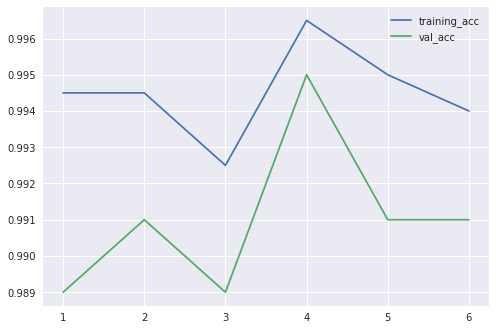

In [15]:
with plt.style.context('seaborn'):
    plt.plot(epoch,history.history['acc'],label='training_acc')
    plt.plot(epoch,history.history['val_acc'],label='val_acc')
    plt.legend()

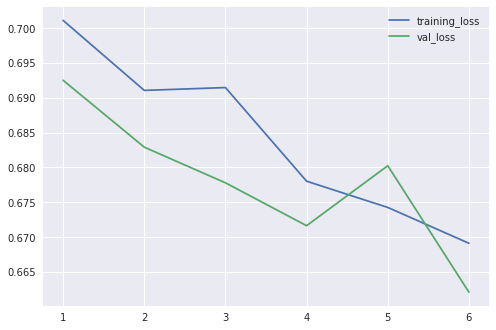

In [14]:
with plt.style.context('seaborn'):
    plt.plot(epoch,history.history['loss'],label='training_loss')
    plt.plot(epoch,history.history['val_loss'],label='val_loss')
    plt.legend()

# BUILDING A CLASSIFIER ON TOP OF THE PRETRAINED MODEL

In [8]:
net = tf.keras.models.Sequential()
net.add(conv_base)
net.add(tf.keras.layers.Flatten())
net.add(tf.keras.layers.Dense(256, activation='relu', input_dim=8 * 8 * 2048))
net.add(tf.keras.layers.Dropout(0.5))
net.add(tf.keras.layers.Dense(25, activation='relu'))
net.add(tf.keras.layers.Dropout(0.5))
net.add(tf.keras.layers.Dense(1, activation='sigmoid'))
net.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [9]:
net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                6425      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

Before you compile and train the model, it’s very important to freeze the convolutional base because we want to use it parameters without updating them. <b>Freezing</b> a layer or set of layers means preventing their weights from being updated during training.  In Keras, you freeze a network by setting its trainable attribute to False:

In [10]:
print('This is the number of trainable weights before freezing the conv base:',
     len(net.trainable_weights))

This is the number of trainable weights before freezing the conv base: 218


In [11]:
conv_base.trainable=False

In [12]:
print('This is the number of trainable weights after freezing the conv base:',
     len(net.trainable_weights))

This is the number of trainable weights after freezing the conv base: 6


With conv_base.trainable=False, only the weights from the two Dense layers that we have added will be trained.